<a href="https://colab.research.google.com/github/sren97/Proyecto-Modelos/blob/main/04%20-%20modelo%20con%20preprocesado%20Label%20Encoding%20y%20XGBoost%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

# **Interacción con los Archivos**

## **Descargar archivos CSV**

Con este código se descargan los archivos directamente desde la plataforma Kaggle mediante la API

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 25% 5.00M/20.1M [00:00<00:00, 46.6MB/s]
100% 20.1M/20.1M [00:00<00:00, 125MB/s] 


## **Descomprimir los archivos**

In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


#**Cargar archivos como Dataframes**

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
auxiliar_df = train_df.copy()

In [ ]:
train_df.columns

Index(['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_EDUCACIONMADRE', 'ESTU_PAGOMATRICULAPROPIO',
       'RENDIMIENTO_GLOBAL'],
      dtype='object')

# **Limpieza de Datos**


## **Funciones de Limpieza**

### **Rendimiento Global**

In [ ]:
def rendimientoglobal(df):
  map_dict = {
    "alto":3,
    "medio-alto":2,
    "medio-bajo":1,
    "bajo": 0
  }
  df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(map_dict)

### **Rendimiento Global Reverso**

In [ ]:
def rendimientoglobalreverse(df):
  df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].round().astype(int)
  map_dict = {
    3:"alto",
    2:"medio-alto",
    1:"medio-bajo",
    0:"bajo"
  }
  df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(map_dict)

### **Estrato**

In [ ]:
def estrato(df):
  map_dict = {
    'Estrato 1': 1,
    'Estrato 2': 3,
    'Estrato 3': 4,
    'Estrato 4': 5,
    'Estrato 5': 6,
    'Estrato 6': 7,
    'Sin Estrato': 2
  }
  df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].map(map_dict)
  moda = df['FAMI_ESTRATOVIVIENDA'].mode()[0]
  # Función para generar valores aleatorios con la misma media y desviación estándar
  def generar_valores(row):
      if pd.isna(row):  # Si el valor es nulo
          return moda
      return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
  df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].apply(generar_valores)


### **Internet**

In [ ]:
#NUEVO - la probabilidad no es una constante, es el promedio de personas que dijieron que si
import random
def internet(df):
  map_dict = {
    'Si': 1,
    'No': 0,
  }
  df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].map(map_dict)
  percent=np.round(df['FAMI_TIENEINTERNET'].mean(),4)

  def assign_value(row):
    est_value=row['FAMI_ESTRATOVIVIENDA']
    if pd.isnull(row['FAMI_TIENEINTERNET']):
        if est_value > 2:
            return 1
        elif np.round(random.random(),4) <= percent:
            return 1
        else:
            return 0
    else:
        return row['FAMI_TIENEINTERNET']

  df['FAMI_TIENEINTERNET'] = df.apply(assign_value, axis=1)

### **Matricula Propia**

In [ ]:
def matriculapropia(df):

    # Agrupar por departamento y calcular la media y desviación estándar del rendimiento global
    res_mean = auxiliar_df.groupby('ESTU_PAGOMATRICULAPROPIO')["RENDIMIENTO_GLOBAL"].mean()
    res_std = auxiliar_df.groupby('ESTU_PAGOMATRICULAPROPIO')["RENDIMIENTO_GLOBAL"].std()

    # Mapear los resultados en el DataFrame
    df['ESTU_PAGOMATRICULAPROPIO'] = df['ESTU_PAGOMATRICULAPROPIO'].map(res_mean)

    # Función para generar valores aleatorios con la misma media y desviación estándar
    def generar_valores_normales(row):
        if pd.isna(row):  # Si el valor es nulo
            mean = res_mean.mean()
            std = res_std.mean()
            return np.random.normal(mean, std)
        return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
    df['ESTU_PAGOMATRICULAPROPIO'] = df['ESTU_PAGOMATRICULAPROPIO'].apply(generar_valores_normales)


### **Horas que Trabaja**

In [ ]:
def horassemanatrabaja(df):
  map_dict = {
    '0': 5,
    'Entre 11 y 20 horas': 3,
    'Entre 21 y 30 horas': 2,
    'Menos de 10 horas': 4,
    'Más de 30 horas': 1
  }
  df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].map(map_dict)
  moda = df['ESTU_HORASSEMANATRABAJA'].mode()[0]

  # Función para generar valores aleatorios con la misma media y desviación estándar
  def generar_valores(row):
      if pd.isna(row):  # Si el valor es nulo
          return moda
      return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
  df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].apply(generar_valores)

### **Valor de la Matricula**

In [ ]:
def valormatriculauniversidad(df):
  map_dict = {
    'Entre 1 millón y menos de 2.5 millones': 1,
    'Entre 2.5 millones y menos de 4 millones': 2,
    'Entre 4 millones y menos de 5.5 millones': 6,
    'Entre 5.5 millones y menos de 7 millones': 7,
    'Entre 500 mil y menos de 1 millón': 3,
    'Menos de 500 mil': 5,
    'Más de 7 millones': 8,
    'No pagó matrícula': 4
  }
  df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(map_dict)
  moda = df['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()[0]
  # Función para generar valores aleatorios con la misma media y desviación estándar
  def generar_valores(row):
      if pd.isna(row):  # Si el valor es nulo
          return moda
      return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
  df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(generar_valores)

### **Educación de Padre**

In [ ]:
def educacionpadre(df):
  map_dict = {
    'Educación profesional completa': 11,
    'Educación profesional incompleta': 10,
    'Ninguno': 1,
    'No Aplica': 7,
    'No sabe': 9,
    'Postgrado': 12,
    'Primaria completa': 3,
    'Primaria incompleta': 2,
    'Secundaria (Bachillerato) completa': 6,
    'Secundaria (Bachillerato) incompleta': 4,
    'Técnica o tecnológica completa': 8,
    'Técnica o tecnológica incompleta': 5
}
  df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].map(map_dict)
  moda = df['FAMI_EDUCACIONPADRE'].mode()[0]

  # Función para generar valores aleatorios con la misma media y desviación estándar
  def generar_valores(row):
      if pd.isna(row):  # Si el valor es nulo
          return moda
      return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
  df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].apply(generar_valores)


### **Educación de Madre**

In [ ]:
def educacionmadre(df):
  map_dict = {
    'Educación profesional completa': 11,
    'Educación profesional incompleta': 10,
    'Ninguno': 1,
    'No Aplica': 4,
    'No sabe': 6,
    'Postgrado': 12,
    'Primaria completa': 3,
    'Primaria incompleta': 2,
    'Secundaria (Bachillerato) completa': 7,
    'Secundaria (Bachillerato) incompleta': 5,
    'Técnica o tecnológica completa': 9,
    'Técnica o tecnológica incompleta': 8
}
  df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].map(map_dict)
  moda = df['FAMI_EDUCACIONMADRE'].mode()[0]
  # Función para generar valores aleatorios con la misma media y desviación estándar
  def generar_valores(row):
      if pd.isna(row):  # Si el valor es nulo
          return moda
      return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
  df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].apply(generar_valores)

### **Periodo**

In [ ]:
def periodo(df):

  df['PERIODO'] = df['PERIODO'].astype(str)

  map_dict = {
    "20183": 5,
    "20184": 1,
    "20194": 9,
    "20195": 3,
    "20196": 4,
    "20202": 8,
    "20203": 6,
    "20212": 2,
    "20213": 7
}
  df['PERIODO'] = df['PERIODO'].map(map_dict)
  moda = df['PERIODO'].mode()[0]
  # Función para generar valores aleatorios con la misma media y desviación estándar
  def generar_valores(row):
      if pd.isna(row):  # Si el valor es nulo
          return moda
      return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
  df['PERIODO'] = df['PERIODO'].apply(generar_valores)

### **Departamento**

In [ ]:
def departamento(df):

    # Agrupar por departamento y calcular la media y desviación estándar del rendimiento global
    res_mean = auxiliar_df.groupby('ESTU_PRGM_DEPARTAMENTO')["RENDIMIENTO_GLOBAL"].mean()

    # Mapear los resultados en el DataFrame
    df['ESTU_PRGM_DEPARTAMENTO'] = df['ESTU_PRGM_DEPARTAMENTO'].map(res_mean)

    # Función para generar valores aleatorios con la misma media y desviación estándar
    def generar_valores_normales(row):
        if pd.isna(row):  # Si el valor es nulo
            mean = auxiliar_df['RENDIMIENTO_GLOBAL'].mean()
            return mean
        return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
    df['ESTU_PRGM_DEPARTAMENTO'] = df['ESTU_PRGM_DEPARTAMENTO'].apply(generar_valores_normales)


### **Programa Acádemico**

In [ ]:
def programaacademico(df):

    # Agrupar por departamento y calcular la media y desviación estándar del rendimiento global
    res_mean = auxiliar_df.groupby('ESTU_PRGM_ACADEMICO')["RENDIMIENTO_GLOBAL"].mean()

    # Mapear los resultados en el DataFrame
    df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].map(res_mean)

    # Función para generar valores aleatorios con la misma media y desviación estándar
    def generar_valores_normales(row):
        if pd.isna(row):  # Si el valor es nulo
            mean = auxiliar_df['RENDIMIENTO_GLOBAL'].mean()
            return mean
        return row

    # Aplicar la función para sustituir los valores nulos con una distribución normal equivalente
    df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(generar_valores_normales)


## **Limpieza Total**

In [ ]:
def limpiar_df(df, predict=False, test=False):
  if not predict:
    if not test:
      rendimientoglobal(df)
    estrato(df)
    internet(df)
    matriculapropia(df)
    valormatriculauniversidad(df)
    educacionpadre(df)
    educacionmadre(df)
    horassemanatrabaja(df)
    departamento(df)
    programaacademico(df)
    periodo(df)
    return df
  elif predict:
    rendimientoglobal(df)

In [ ]:
limpiar_df(auxiliar_df, predict=True)
train_df2 = limpiar_df(train_df)
test_df2 = limpiar_df(test_df, test=True)

# **XGBoost Classifier**

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = train_df2.copy()

# Separar características (X) y la variable objetivo (y)
X = df.drop(columns=["RENDIMIENTO_GLOBAL","ID"], axis=1)
y = df["RENDIMIENTO_GLOBAL"]

# Dividir el conjunto de datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Inicializar el modelo de XGBoost para clasificación
xgb_classifier = xgb.XGBClassifier(n_estimators=350,
                                   learning_rate=0.4,
                                   max_depth=5,
                                   random_state=42)

# Entrenar el modelo
xgb_classifier.fit(X_train, y_train)

# Predecir los valores del conjunto de prueba
y_pred = xgb_classifier.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy}')


Precisión: 0.44288808664259927


# **Importancia de Columnas en XGBoost Classifier**

                          Feature  Importance
1             ESTU_PRGM_ACADEMICO    0.236287
3  ESTU_VALORMATRICULAUNIVERSIDAD    0.218352
6              FAMI_TIENEINTERNET    0.091743
2          ESTU_PRGM_DEPARTAMENTO    0.084523
8             FAMI_EDUCACIONMADRE    0.075052
5            FAMI_ESTRATOVIVIENDA    0.071568
4         ESTU_HORASSEMANATRABAJA    0.061178
0                         PERIODO    0.060223
7             FAMI_EDUCACIONPADRE    0.059834
9        ESTU_PAGOMATRICULAPROPIO    0.041240


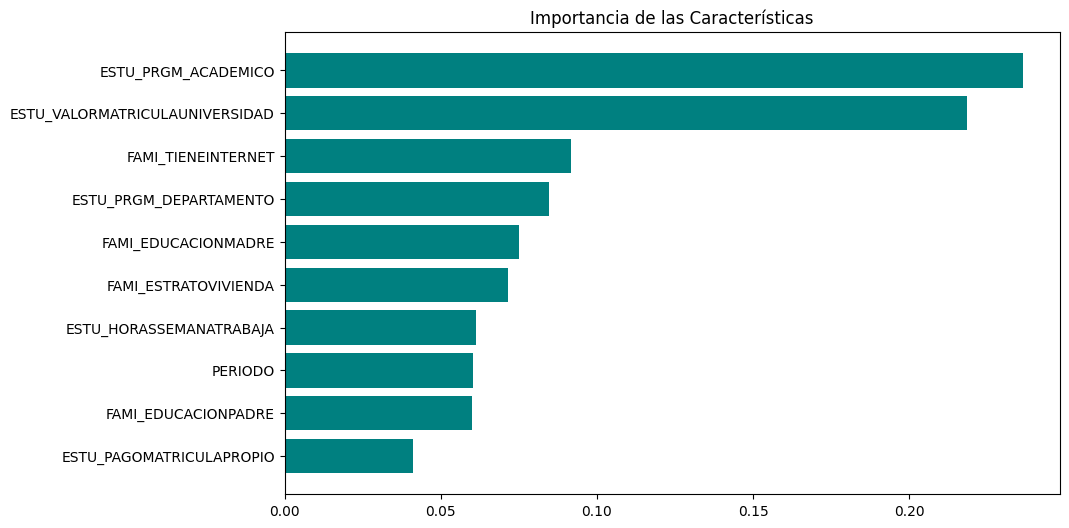

In [ ]:
# Obtener las importancias de las características en el modelo de clasificación
importances = xgb_classifier.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar las características por importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(feature_importances_df)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.show()

# **Predicción Kaggle**

In [ ]:
df_test=test_df2.copy()
y = df_test["ID"]
df_test.drop(columns=["ID","Unnamed: 0"],axis=1,inplace=True)
predicciones = xgb_classifier.predict(df_test)
y=pd.concat([y,pd.DataFrame(predicciones,columns=["RENDIMIENTO_GLOBAL"])],axis=1)
rendimientoglobalreverse(y)
print(y)
y.to_csv("submission.csv",index=False)

            ID RENDIMIENTO_GLOBAL
0       550236               bajo
1        98545         medio-alto
2       499179               alto
3       782980               bajo
4       785185               bajo
...        ...                ...
296781  496981         medio-bajo
296782  209415               alto
296783  239074         medio-alto
296784  963852               alto
296785  792650               alto

[296786 rows x 2 columns]
